# Fast Neural Style Transfer

In [1]:
import time 

import matplotlib.pyplot as plt
import numpy as np
import torch
# For getting VGG model
import torchvision.models.vgg as vgg
import torch.utils.model_zoo as model_zoo
# Image transformation pipeline
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.optim import Adam
from torch.autograd import Variable
from PIL import Image, ImageFile
from tqdm import tqdm_notebook

from fast_neural_style.transformer_net import TransformerNet
from fast_neural_style.utils import (
    gram_matrix, recover_image, tensor_normalizer
)
from fast_neural_style.loss_network import LossNetwork

%matplotlib inline
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
SEED = 1080
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    kwargs = {'num_workers': 4, 'pin_memory': True}
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    kwargs = {}

In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 4
DATASET = "../coco_2017/"
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE), 
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(), tensor_normalizer()])
# http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder
train_dataset = datasets.ImageFolder(DATASET, transform)
# http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    loss_network = LossNetwork()
    loss_network.to(device)
loss_network.eval()

LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReL

In [5]:
STYLE_IMAGE = "../style_images/mosaic.jpg"
style_img = Image.open(STYLE_IMAGE).convert('RGB')
with torch.no_grad():
    style_img_tensor = transforms.Compose([
        transforms.Resize(IMAGE_SIZE* 2),
        transforms.ToTensor(),
        tensor_normalizer()]
    )(style_img).unsqueeze(0)
    # assert np.sum(style_img - recover_image(style_img_tensor.numpy())[0].astype(np.uint8)) < 3 * style_img_tensor.size()[2] * style_img_tensor.size()[3]
    style_img_tensor = style_img_tensor.to(device)

Sanity check:

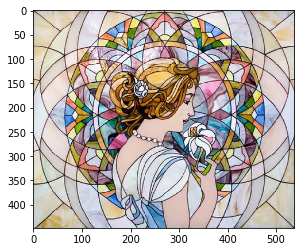

In [6]:
plt.imshow(recover_image(style_img_tensor.cpu().numpy())[0])

Precalculate gram matrices of the style image:

In [7]:
# http://pytorch.org/docs/master/notes/autograd.html#volatile
with torch.no_grad():
    style_loss_features = loss_network(style_img_tensor)
    gram_style = [gram_matrix(y) for y in style_loss_features]

In [8]:
style_loss_features._fields

('relu1', 'relu2', 'relu3', 'relu4', 'relu5')

In [9]:
for i in range(len(style_loss_features)):
    tmp = style_loss_features[i].cpu().numpy()
    print(i, np.mean(tmp), np.std(tmp))

0 0.7157093 1.5986855
1 1.137745 2.8325207
2 1.4512998 4.9942584
3 0.37039497 1.4787791
4 0.07999754 0.4285575


In [10]:
for i in range(len(style_loss_features)):
    print(i, gram_style[i].numel(), gram_style[i].size())

0 4096 torch.Size([1, 64, 64])
1 16384 torch.Size([1, 128, 128])
2 65536 torch.Size([1, 256, 256])
3 262144 torch.Size([1, 512, 512])
4 262144 torch.Size([1, 512, 512])


## Train the Transformer / Image Generator
Utility function to save debug images during training:

In [11]:
def save_debug_image(tensor_orig, tensor_transformed, filename):
    assert tensor_orig.size() == tensor_transformed.size()
    result = Image.fromarray(recover_image(tensor_transformed.cpu().numpy())[0])
    orig = Image.fromarray(recover_image(tensor_orig.cpu().numpy())[0])
    new_im = Image.new('RGB', (result.size[0] * 2 + 5, result.size[1]))
    new_im.paste(orig, (0,0))
    new_im.paste(result, (result.size[0] + 5,0))
    new_im.save(filename)

In [12]:
%mkdir -p ../debug

In [13]:
transformer = TransformerNet()
mse_loss = torch.nn.MSELoss()
# l1_loss = torch.nn.L1Loss()
transformer.to(device)

TransformerNet(
  (conv1): ConvLayer(
    (reflection_pad): ReflectionPad2d((4, 4, 4, 4))
    (conv2d): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
  )
  (in1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  )
  (in2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv3): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  )
  (in3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (res1): ResidualBlock(
    (conv1): ConvLayer(
      (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
      (conv2d): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    )
    (in1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (

In [14]:
torch.set_default_tensor_type('torch.FloatTensor')
    
def train(steps, base_steps=0):
    transformer.train()
    count = 0
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_reg_loss = 0.   
    while True:
        for x, _ in train_loader:
            count += 1
            optimizer.zero_grad()
            x = x.to(device)             
            y = transformer(x)            
                        
            with torch.no_grad():
                xc = x.detach()

            features_y = loss_network(y)
            features_xc = loss_network(xc)

            with torch.no_grad():
                f_xc_c = features_xc[2].detach()

            content_loss = CONTENT_WEIGHT * mse_loss(features_y[2], f_xc_c)

            reg_loss = REGULARIZATION * (
                torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
                torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

            style_loss = 0.
            for l, weight in enumerate(STYLE_WEIGHTS):
                gram_s = gram_style[l]
                gram_y = gram_matrix(features_y[l])
                style_loss += float(weight) * mse_loss(gram_y, gram_s.expand_as(gram_y))
                
            total_loss = content_loss + style_loss + reg_loss 
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss
            agg_style_loss += style_loss
            agg_reg_loss += reg_loss

            if count % LOG_INTERVAL == 0:
                mesg = "{} [{}/{}] content: {:.2f}  style: {:.2f}  reg: {:.2f} total: {:.6f}".format(
                            time.ctime(), count, steps,
                            agg_content_loss / LOG_INTERVAL,
                            agg_style_loss / LOG_INTERVAL,
                            agg_reg_loss / LOG_INTERVAL,
                            (agg_content_loss + agg_style_loss + 
                             agg_reg_loss ) / LOG_INTERVAL
                        )
                print(mesg)
                agg_content_loss = 0.
                agg_style_loss = 0.
                agg_reg_loss = 0.
                agg_stable_loss = 0.
                transformer.eval()
                y = transformer(x)
                save_debug_image(x, y.detach(), "../debug/{}.png".format(base_steps + count))
                transformer.train()
                
            if count >= steps:
                return

In [15]:
CONTENT_WEIGHT = 1
STYLE_WEIGHTS = np.array([1e-1, 1, 1e1, 5, 1e1]) * 1e4
REGULARIZATION = 1e-6
LOG_INTERVAL = 50

LR = 1e-3
optimizer = Adam(transformer.parameters(), LR)


In [16]:
len(train_loader)

10168

In [17]:
train(1000, 0)

Fri Jun 22 12:47:04 2018 [50/1000] content: 21.53  style: 18.87  reg: 0.11 total: 40.513065
Fri Jun 22 12:47:37 2018 [100/1000] content: 21.18  style: 11.35  reg: 0.15 total: 32.687626
Fri Jun 22 12:48:09 2018 [150/1000] content: 19.98  style: 9.84  reg: 0.17 total: 29.999338
Fri Jun 22 12:48:41 2018 [200/1000] content: 18.81  style: 9.01  reg: 0.19 total: 28.005775
Fri Jun 22 12:49:13 2018 [250/1000] content: 17.73  style: 8.61  reg: 0.20 total: 26.536188
Fri Jun 22 12:49:46 2018 [300/1000] content: 17.31  style: 8.87  reg: 0.20 total: 26.375546
Fri Jun 22 12:50:18 2018 [350/1000] content: 16.86  style: 8.21  reg: 0.20 total: 25.274117
Fri Jun 22 12:50:50 2018 [400/1000] content: 16.37  style: 8.31  reg: 0.20 total: 24.880304
Fri Jun 22 12:51:23 2018 [450/1000] content: 16.20  style: 8.07  reg: 0.21 total: 24.483412
Fri Jun 22 12:51:55 2018 [500/1000] content: 15.45  style: 7.96  reg: 0.21 total: 23.621611
Fri Jun 22 12:52:27 2018 [550/1000] content: 15.15  style: 7.93  reg: 0.21 tota

In [18]:
optimizer = Adam(transformer.parameters(), LR * 0.5)

In [19]:
train(3000, 1000)

Fri Jun 22 12:57:50 2018 [50/3000] content: 13.47  style: 7.70  reg: 0.21 total: 21.374929
Fri Jun 22 12:58:23 2018 [100/3000] content: 13.02  style: 7.66  reg: 0.21 total: 20.885668
Fri Jun 22 12:58:55 2018 [150/3000] content: 13.07  style: 7.72  reg: 0.21 total: 21.001320
Fri Jun 22 12:59:27 2018 [200/3000] content: 12.94  style: 7.52  reg: 0.21 total: 20.671774
Fri Jun 22 12:59:59 2018 [250/3000] content: 12.97  style: 7.63  reg: 0.21 total: 20.817743
Fri Jun 22 13:00:32 2018 [300/3000] content: 12.67  style: 7.46  reg: 0.21 total: 20.338404
Fri Jun 22 13:01:04 2018 [350/3000] content: 12.83  style: 7.74  reg: 0.21 total: 20.785248
Fri Jun 22 13:01:36 2018 [400/3000] content: 12.67  style: 7.58  reg: 0.21 total: 20.463888
Fri Jun 22 13:02:08 2018 [450/3000] content: 12.30  style: 7.48  reg: 0.21 total: 19.996574
Fri Jun 22 13:02:40 2018 [500/3000] content: 12.90  style: 7.76  reg: 0.21 total: 20.864584
Fri Jun 22 13:03:13 2018 [550/3000] content: 13.38  style: 8.04  reg: 0.21 total:

In [20]:
save_model_path = "../models/mosaic_4000_unstable_vgg19.pth"
torch.save(transformer.state_dict(), save_model_path)

In [21]:
LOG_INTERVAL = 100
optimizer = Adam(transformer.parameters(), LR * 0.1)
train(6000, 4000)

Fri Jun 22 13:30:38 2018 [100/6000] content: 11.04  style: 7.17  reg: 0.22 total: 18.433414
Fri Jun 22 13:31:42 2018 [200/6000] content: 11.09  style: 7.10  reg: 0.22 total: 18.410851
Fri Jun 22 13:32:47 2018 [300/6000] content: 10.83  style: 7.16  reg: 0.22 total: 18.201572
Fri Jun 22 13:33:54 2018 [400/6000] content: 10.87  style: 7.14  reg: 0.22 total: 18.233467
Fri Jun 22 13:35:00 2018 [500/6000] content: 10.82  style: 7.14  reg: 0.22 total: 18.181248
Fri Jun 22 13:36:07 2018 [600/6000] content: 11.04  style: 7.12  reg: 0.22 total: 18.372707
Fri Jun 22 13:37:13 2018 [700/6000] content: 11.01  style: 7.20  reg: 0.22 total: 18.427862
Fri Jun 22 13:38:20 2018 [800/6000] content: 10.92  style: 7.03  reg: 0.22 total: 18.168201
Fri Jun 22 13:39:26 2018 [900/6000] content: 10.74  style: 7.05  reg: 0.22 total: 18.004976
Fri Jun 22 13:40:33 2018 [1000/6000] content: 10.87  style: 7.16  reg: 0.22 total: 18.247181
Fri Jun 22 13:41:39 2018 [1100/6000] content: 10.98  style: 7.19  reg: 0.22 tot

In [22]:
save_model_path = "../models/mosaic_10000_unstable_vgg19.pth"
torch.save(transformer.state_dict(), save_model_path)

In [23]:
import glob
fnames = glob.glob(DATASET + r"/*/*")
len(fnames)

40670

In [24]:
transformer = transformer.eval()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


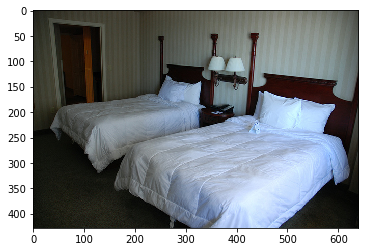

In [33]:
img = Image.open(fnames[70]).convert('RGB')
transform = transforms.Compose([
                                
                                transforms.ToTensor(),
                                tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

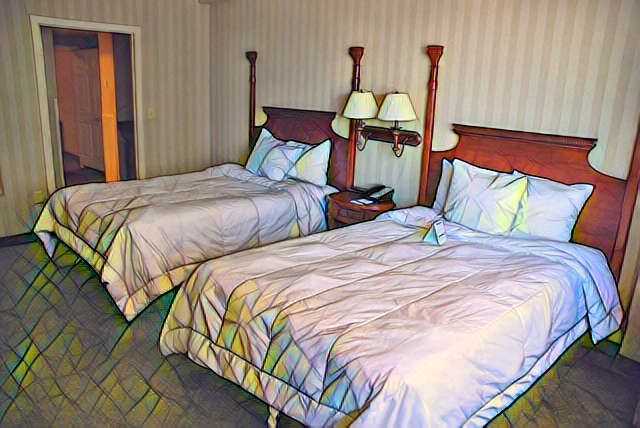

In [34]:
Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


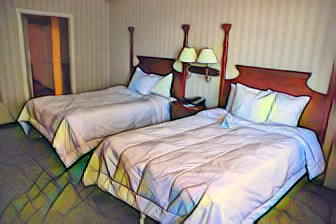

In [35]:
transform = transforms.Compose([
                                transforms.Resize(IMAGE_SIZE),
                                transforms.ToTensor(),
                                tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])

torch.Size([1, 3, 512, 512])


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()


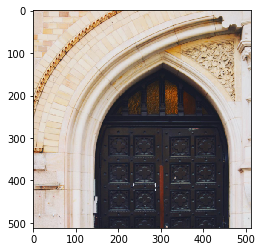

In [36]:
img = Image.open("../content_images/amber.jpg").convert('RGB')
transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
print(img_tensor.size())
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

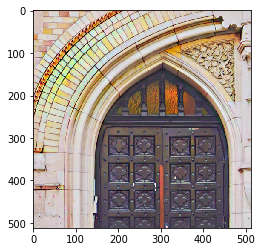

In [37]:
plt.imshow(recover_image(img_output.data.cpu().numpy())[0])

torch.Size([1, 3, 224, 224])


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()


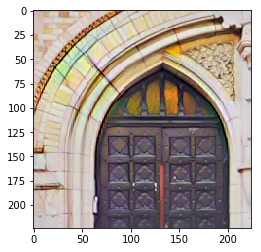

In [38]:
img = Image.open("../content_images/amber.jpg").convert('RGB')
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
print(img_tensor.size())
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_output.data.cpu().numpy())[0])

In [32]:
output_img = Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])
output_img.save("amber.png")